In [1]:
import pandas as pd
import numpy as np
import os
import hddm

import glob
import re
import seaborn as sns

import nideconv

import matplotlib.pyplot as plt
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## First, re-do deconvolutions

In [2]:
## load all extracted signals
all_csvs = glob.glob('./derivatives/ds-*/extracted_signal/sub-*/func/*subroi*.csv')

reg = re.compile('.*ds-(?P<ds>\d+)/extracted_signal/sub-(?P<sub>\d+)/func/sub-.*_task-randomdotmotion_run-(?P<run>\d+)_space-T1w_desc-preproc_desc-stn(?P<hemisphere>\S+)_subroi-(?P<roi>\S)_roi.*')
reg.match(all_csvs[1]).groupdict()

{'ds': '01', 'hemisphere': 'r', 'roi': 'A', 'run': '01', 'sub': '19'}

In [3]:
df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    d['signal'] = pd.read_csv(fn, index_col=0).mean(1)
    d = pd.DataFrame(d)
    d['t'] = np.arange(0, d.shape[0]*3, 3)
    
    df.append(d)

df = pd.concat(df, axis=0)
df['ds'] = df['ds'].astype(int)
df['run'] = df['run'].astype(int)
df['sub'] = df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = df.loc[df.ds==1,'sub'].max()
df.loc[df.ds==2,'sub'] = df.loc[df.ds==2,'sub']+max_sub_ds1

In [4]:
df_pivoted = df.rename(columns={'sub':'subject'}).pivot_table(values=['signal'], index=['ds', 'subject', 'run', 't'], columns=['hemisphere', 'roi'])
df_pivoted = df_pivoted.reset_index(level=0, drop=True)
df_pivoted.columns = ['_'.join(col) for col in df_pivoted.columns]

df_pivoted

signal_l_A  signal_l_B  signal_l_C  signal_r_A  signal_r_B  \
subject run t                                                                  
1       1   0      -0.239806   -0.178589   -0.947851   -0.679461   -1.369150   
            3      -0.551264    0.186332   -0.475592   -0.391721   -1.193000   
            6       0.015289    0.063214   -0.388570   -0.267504   -0.838869   
            9       0.260700    0.141860    0.195549    0.205334   -0.260657   
            12     -0.165794    0.051937    0.033031    0.230826   -0.258694   
...                      ...         ...         ...         ...         ...   
34      3   1146    2.777787   -2.233519   -2.332652    0.684276   -1.656119   
            1149    3.213214   -0.653678    0.677587    0.063427   -0.363088   
            1152    4.209321   -0.873387    0.966135    1.622981   -1.927441   
            1155    3.062933   -1.468690    0.490794    1.000483   -1.419859   
            1158    4.879514   -0.182001    0.597525    2.833500    0.297056   

                  signal_r_C  
subject run t                 
1       1   0       0.074469  
            3       0.361400  
            6       0.328726  
            9      -0.294576  
            12      0.980462  
...                      ...  
34      3   1146   -1.584448  
            1149   -1.223178  
            1152   -0.311371  
            1155    0.381857  
            1158   -0.075293  

[37539 rows x 6 columns]

In [5]:
pd.read_csv('./derivatives/ds-01/event_files/sub-01_task-randomdotmotion_run-01_events.tsv', sep='\t')

,onset,trial_type
0,7.25,easy
1,16.25,hard
2,26.75,hard
3,35.75,easy
4,42.50,easy
...,...,...
430,1114.25,response_left
431,1124.00,response_left
432,1132.25,response_right
433,1142.00,response_right


In [6]:
pd.read_csv('sourcedata/behavior.csv')['subj_idx'].unique()  # only ds1

array([14, 15,  1,  9, 10, 13, 19,  4,  2,  6, 16, 11, 18, 17,  7,  8,  3,
        5, 12])

In [7]:
tmp = pd.read_csv('sourcedata/behavior.csv')
tmp[(tmp.subj_idx == 1) & (tmp.block==1)] 

,Unnamed: 0,block,trial_NR,cue_delay,stim_delay,cue,coherence,difficulty,stimulus,response,rt,correct,onset_cue,onset_stim,cue_validity,subj_idx,subj_idx_exp
768,768,1,1,1500,1750,left,0.16,easy,left,1,1071.0,1,7.50,10.25,valid,1,12
769,769,1,2,1500,1750,left,0.08,hard,right,1,856.0,0,16.50,19.25,invalid,1,12
770,770,1,3,1500,3250,left,0.08,hard,right,1,1029.0,0,25.50,29.75,invalid,1,12
771,771,1,4,1500,3250,left,0.16,easy,right,1,928.0,0,34.50,38.75,invalid,1,12
772,772,1,5,1500,1000,neutral,0.16,easy,left,1,1490.0,1,43.50,45.50,neutral,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,891,1,124,2250,1000,right,0.08,hard,right,1,753.0,0,1115.25,1117.25,valid,1,12
892,892,1,125,750,3250,left,0.08,hard,right,1,844.0,0,1122.75,1127.00,invalid,1,12
893,893,1,126,750,2500,neutral,0.16,easy,right,2,959.0,1,1131.75,1135.25,neutral,1,12
894,894,1,127,750,3250,right,0.16,easy,right,2,945.0,1,1140.75,1145.00,valid,1,12


In [8]:
tmp = pd.read_csv('./derivatives/ds-01/event_files/sub-10_task-randomdotmotion_run-01_events.tsv', sep='\t')  # 3 seconds earlier than 'sourcedata/behavior.csv'
tmp[tmp.trial_type.isin(['cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'])].sort_values('onset')

,onset,trial_type
185,3.00,cue_left
0,7.25,hard
186,12.75,cue_right
1,17.00,hard
187,23.25,cue_neutral
...,...,...
125,1130.75,easy
311,1137.75,cue_left
126,1142.00,hard
312,1146.75,cue_neutral


In [9]:
tmp = pd.read_csv('sourcedata/behavior.csv')
tmp[(tmp.subj_idx == 10) & (tmp.block==1)] 

,Unnamed: 0,block,trial_NR,cue_delay,stim_delay,cue,coherence,difficulty,stimulus,response,rt,correct,onset_cue,onset_stim,cue_validity,subj_idx,subj_idx_exp
1536,1536,1,1,0,3250,left,0.08,hard,left,-1,NaN,0,6.00,10.25,valid,10,14
1537,1537,1,2,750,3250,right,0.08,hard,left,2,572.0,0,15.75,20.00,invalid,10,14
1538,1538,1,3,2250,1000,neutral,0.08,hard,left,1,804.0,1,26.25,28.25,neutral,10,14
1539,1539,1,4,0,2500,neutral,0.08,hard,left,1,658.0,1,33.00,36.50,neutral,10,14
1540,1540,1,5,750,1000,right,0.08,hard,left,1,1004.0,1,42.75,44.75,invalid,10,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,1659,1,124,0,1000,right,0.16,easy,right,1,1122.0,0,1113.00,1115.00,valid,10,14
1660,1660,1,125,0,1000,neutral,0.08,hard,right,2,855.0,1,1122.00,1124.00,neutral,10,14
1661,1661,1,126,0,1750,neutral,0.16,easy,right,2,940.0,1,1131.00,1133.75,neutral,10,14
1662,1662,1,127,750,3250,left,0.08,hard,right,2,978.0,1,1140.75,1145.00,invalid,10,14


In [10]:
tmp = pd.read_pickle('./derivatives/behavior.pkl')
subject = '05'
block = 3
run = str(block).zfill(2)
ds = 'ds-01'

tmp.loc[(tmp.subject==subject) & (tmp.ds == ds) & (tmp.block == block)]

,block,trial_NR,cue_delay,stim_delay,cue,coherence,difficulty,stimulus,response,rt,correct,onset_cue,onset_stim,subject,ds,cue congruency
256,3,1,1500,1750,neutral,0.08,hard,left,1,623,1,7.50,10.25,05,ds-01,neutral
257,3,2,1500,3250,right,0.08,hard,left,1,677,1,16.50,20.75,05,ds-01,incongruent
258,3,3,2250,3250,neutral,0.16,easy,left,1,610,1,26.25,30.50,05,ds-01,neutral
259,3,4,2250,1750,neutral,0.16,easy,left,1,1107,1,35.25,38.00,05,ds-01,neutral
260,3,5,2250,2500,left,0.16,easy,left,1,524,1,44.25,47.75,05,ds-01,congruent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,3,124,2250,2500,neutral,0.08,hard,right,1,675,0,1115.25,1118.75,05,ds-01,neutral
380,3,125,1500,3250,neutral,0.08,hard,right,-1,-1,0,1123.50,1127.75,05,ds-01,neutral
381,3,126,2250,2500,right,0.08,hard,left,2,5,0,1133.25,1136.75,05,ds-01,incongruent
382,3,127,2250,3250,left,0.16,easy,left,-1,-1,0,1142.25,1146.50,05,ds-01,congruent


In [11]:
tmp = pd.read_csv('./derivatives/{}/event_files/sub-{}_task-randomdotmotion_run-{}_events.tsv'.format(ds, subject, run), sep='\t')  # 3 seconds earlier than 'sourcedata/behavior.csv'
tmp[tmp.trial_type.isin(['cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'])].sort_values('onset')

,onset,trial_type
203,4.50,cue_neutral
0,7.25,hard
204,13.50,cue_right
1,17.75,hard
205,23.25,cue_neutral
...,...,...
125,1133.75,hard
329,1139.25,cue_left
126,1143.50,easy
330,1148.25,cue_neutral


In [32]:
behavior

,block,trial_NR,cue_delay,stim_delay,cue,coherence,difficulty,stimulus,response,rt,correct,onset_cue,onset_stim,subject,ds,cue congruency,sub,onset_response
0,1,1,1500,1750,left,0.16,easy,left,1,1071,1,7.50,10.25,01,ds-01,congruent,1,11.321
1,1,2,1500,1750,left,0.08,hard,right,1,856,0,16.50,19.25,01,ds-01,incongruent,1,20.106
2,1,3,1500,3250,left,0.08,hard,right,1,1029,0,25.50,29.75,01,ds-01,incongruent,1,30.779
3,1,4,1500,3250,left,0.16,easy,right,1,928,0,34.50,38.75,01,ds-01,incongruent,1,39.678
4,1,5,1500,1000,neutral,0.16,easy,left,1,1490,1,43.50,45.50,01,ds-01,neutral,1,46.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,3,124,2250,1750,neutral,0.35,easy,left,1,660,1,1115.25,1118.00,15,ds-02,neutral,34,1118.660
380,3,125,750,2500,left,0.35,easy,right,2,670,1,1122.75,1126.25,15,ds-02,incongruent,34,1126.920
381,3,126,1500,3250,right,0.35,easy,right,2,862,1,1132.50,1136.75,15,ds-02,congruent,34,1137.612
382,3,127,750,1000,neutral,0.35,easy,right,2,610,1,1140.75,1142.75,15,ds-02,neutral,34,1143.360


In [31]:
## get events
behavior = pd.read_pickle('./derivatives/behavior.pkl')
behavior['sub'] = behavior['subject']
behavior.loc[behavior['ds']=='ds-02', 'sub'] = behavior.loc[behavior['ds']=='ds-02', 'sub'].astype(int) + behavior.loc[behavior['ds']=='ds-01', 'sub'].astype(int).max()
behavior['sub'] = behavior['sub'].astype(int)
behavior['onset_response'] = behavior['onset_stim'] + behavior['rt']/1000

events_cue = behavior[['sub', 'block', 'onset_cue']]
events_cue['event_type'] = 'cue'
events_cue = events_cue.rename(columns={'block': 'run', 'onset_cue': 'onset'})

events_stim = behavior[['sub', 'block', 'onset_stim']]
events_stim['event_type'] = 'stim'
events_stim = events_stim.rename(columns={'block': 'run', 'onset_stim': 'onset'})

events = pd.concat((events_cue, events_stim))
events = events.sort_values(by=['sub', 'run', 'onset'])
events = events.rename(columns={'sub': 'subject'})
events.head()

events_deconv = events.set_index(['subject', 'run', 'event_type'])
events_deconv.head()

## correct onsets due to STC
events_deconv['onset'] -= 1.5

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [13]:
events_deconv.loc[(1, 3)]

,onset
event_type,
cue,6.00
stim,9.50
cue,15.75
stim,19.25
cue,22.50
...,...
stim,1134.50
cue,1139.25
stim,1141.25


In [14]:
## get confounds
all_csvs = glob.glob('./derivatives/ds-*/fmriprep_confounds/sub-*_task-randomdotmotion_run-*_desc-confounds_regressors.tsv')

reg = re.compile('.*ds-(?P<ds>\d+)/fmriprep_confounds/sub-(?P<sub>\d+)_.*_run-(?P<run>\d+)_.*')
reg.match(all_csvs[1]).groupdict()


confounds_df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    tmp = pd.read_csv(fn, sep='\t')
    tmp['sub'] = d['sub']
    tmp['run'] = d['run']
    tmp['ds'] = d['ds']
    confounds_df.append(tmp)

confounds_df = pd.concat(confounds_df, axis=0)
confounds_df['ds'] = confounds_df['ds'].astype(int)
confounds_df['run'] = confounds_df['run'].astype(int)
confounds_df['subject'] = confounds_df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = confounds_df.loc[confounds_df.ds==1,'subject'].max()
confounds_df.loc[confounds_df.ds==2,'subject'] = confounds_df.loc[confounds_df.ds==2,'subject']+max_sub_ds1
confounds_df = confounds_df.sort_values(['ds', 'subject', 'run']).set_index(['ds', 'subject', 'run'])

# Include confounds: 5 ACompCor regressors, cosines for drift, DVARS, rotation & translation params
confounds_deconv = confounds_df.reset_index(level=0, drop=True)
include_confounds = ['a_comp_cor_0' + str(x) for x in range(5)] + ['cosine' + str(x).zfill(2) for x in range(17)]
include_confounds = include_confounds + ['dvars', 'framewise_displacement']
include_confounds = include_confounds + ['rot_' + a for a in ['x', 'y', 'z']]
include_confounds = include_confounds + ['trans_' + a for a in ['x', 'y', 'z']]
confounds_deconv = confounds_deconv[include_confounds]

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [15]:
confounds_deconv

a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  a_comp_cor_03  \
subject run                                                               
1       1        -0.076368      -0.024852       0.008989      -0.092645   
        1        -0.154372       0.013430      -0.084220       0.008871   
        1        -0.139079       0.046189      -0.037292       0.061723   
        1        -0.074539       0.044704       0.000576       0.052884   
        1        -0.006416       0.021674       0.051981       0.045026   
...                    ...            ...            ...            ...   
34      3        -0.034023      -0.050900       0.022628      -0.001950   
        3         0.003881      -0.056307       0.085950       0.039047   
        3        -0.025902      -0.054054       0.048134      -0.004686   
        3        -0.007097      -0.029584       0.024528      -0.056113   
        3        -0.012488      -0.022494       0.153961       0.004180   

             a_comp_cor_04  cosine00  cosine01  cosine02  cosine03  cosine04  \
subject run                                                                    
1       1         0.145740  0.071888  0.071886  0.071883  0.071879  0.071874   
        1         0.135120  0.071883  0.071867  0.071841  0.071803  0.071755   
        1         0.092630  0.071874  0.071829  0.071755  0.071652  0.071519   
        1         0.022459  0.071860  0.071772  0.071628  0.071425  0.071164   
        1        -0.017255  0.071841  0.071697  0.071457  0.071122  0.070693   
...                    ...       ...       ...       ...       ...       ...   
34      3        -0.010041 -0.071841  0.071697 -0.071457  0.071122 -0.070693   
        3         0.050555 -0.071860  0.071772 -0.071628  0.071425 -0.071164   
        3        -0.002463 -0.071874  0.071829 -0.071755  0.071652 -0.071519   
        3        -0.035224 -0.071883  0.071867 -0.071841  0.071803 -0.071755   
        3         0.066808 -0.071888  0.071886 -0.071883  0.071879 -0.071874   

             ...  cosine15  cosine16      dvars  framewise_displacement  \
subject run  ...                                                          
1       1    ...  0.071737  0.071717        NaN                     NaN   
        1    ...  0.070528  0.070354  29.534298                0.106529   
        1    ...  0.068132  0.067652  22.207958                0.055383   
        1    ...  0.064587  0.063665  19.671873                0.040175   
        1    ...  0.059955  0.058466  19.645233                0.054571   
...          ...       ...       ...        ...                     ...   
34      3    ...  0.059955 -0.058466  35.824867                0.061488   
        3    ...  0.064587 -0.063665  34.041985                0.049583   
        3    ...  0.068132 -0.067652  34.827942                0.054295   
        3    ...  0.070528 -0.070354  34.422466                0.045574   
        3    ...  0.071737 -0.071717  40.537369                0.220564   

                rot_x     rot_y     rot_z   trans_x   trans_y   trans_z  
subject run                                                              
1       1    0.001524  0.000356 -0.000161 -0.082265 -0.115355  0.062333  
        1    0.000932  0.000164  0.000000 -0.070083 -0.092359  0.086446  
        1    0.000673  0.000346 -0.000137 -0.065494 -0.095517  0.105258  
        1    0.000511  0.000322 -0.000230 -0.059378 -0.081704  0.098941  
        1    0.000099  0.000239 -0.000194 -0.051345 -0.065291  0.095407  
...               ...       ...       ...       ...       ...       ...  
34      3    0.004014 -0.006609 -0.002313 -0.049395 -0.036771 -0.894691  
        3    0.003823 -0.006859 -0.002275 -0.045967 -0.054848 -0.898775  
        3    0.003772 -0.006839 -0.002212 -0.052122 -0.077782 -0.880235  
        3    0.003414 -0.006995 -0.002399 -0.048022 -0.073822 -0.877784  
        3    0.004830 -0.007111 -0.003020 -0.057276 -0.046430 -0.954047  

[37539 rows x 30 columns]

## Fourier basis set deconvolution

In [16]:
from nideconv import GroupResponseFitter
    
gmodel = GroupResponseFitter(df_pivoted, 
                             events_deconv, 
                             confounds=confounds_deconv.fillna(0),
                             input_sample_rate=1/3, concatenate_runs=True)
gmodel.add_event('stim', basis_set='fourier', n_regressors=7, interval=[0, 18])
gmodel.add_event('cue', basis_set='fourier', n_regressors=7, interval=[0, 18])

gmodel.fit()

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'N=34')

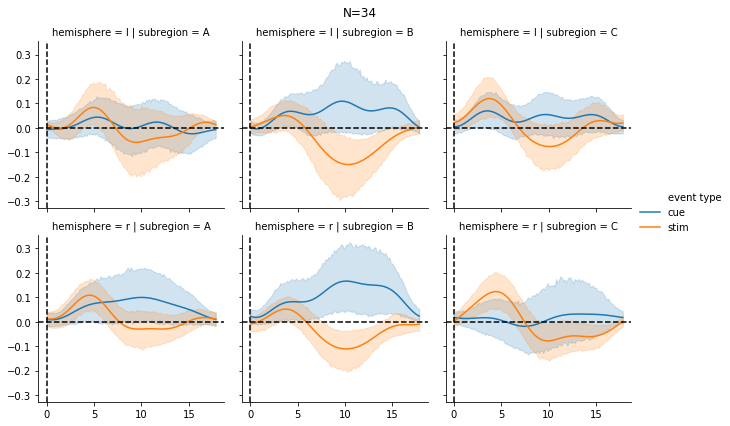

In [17]:
tmp = gmodel.get_subjectwise_timecourses()
tmp = tmp.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tmp['hemisphere'] = tmp['roi'].str.split('_').apply(lambda x: x[1])
tmp['subregion'] = tmp['roi'].str.split('_').apply(lambda x: x[2])

## plot
fac = sns.FacetGrid(tmp, row='hemisphere', col='subregion')

fac.map_dataframe(sns.lineplot,
                  x='time',
                  hue='event type',
                  y='signal',
                  color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

plt.subplots_adjust(top=0.9)
fac.fig.suptitle('N=34')

## only event type cue

In [18]:
confounds_deconv.columns

Index(['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
       'a_comp_cor_04', 'cosine00', 'cosine01', 'cosine02', 'cosine03',
       'cosine04', 'cosine05', 'cosine06', 'cosine07', 'cosine08', 'cosine09',
       'cosine10', 'cosine11', 'cosine12', 'cosine13', 'cosine14', 'cosine15',
       'cosine16', 'dvars', 'framewise_displacement', 'rot_x', 'rot_y',
       'rot_z', 'trans_x', 'trans_y', 'trans_z'],
      dtype='object')

In [19]:
events_deconv

onset
subject run event_type         
1       1   cue            6.00
            stim           8.75
            cue           15.00
            stim          17.75
            cue           24.00
...                         ...
34      3   stim        1135.25
            cue         1139.25
            stim        1141.25
            cue         1148.25
            stim        1151.75

[24830 rows x 1 columns]

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


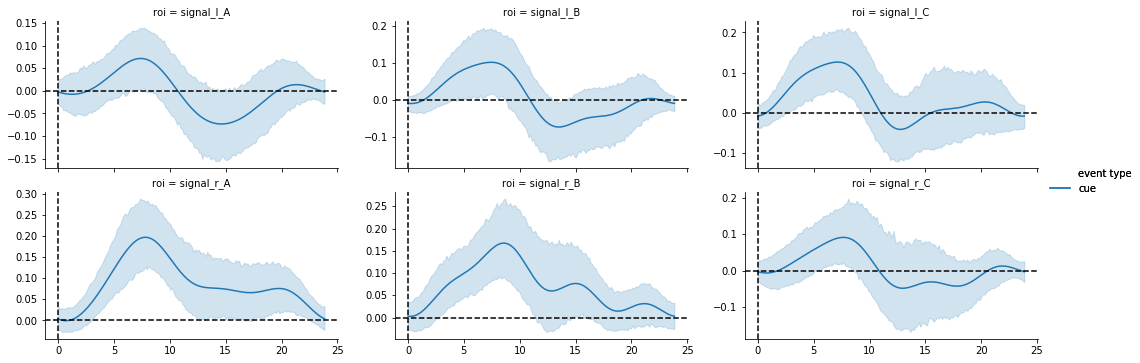

In [21]:
from nideconv import GroupResponseFitter
    
gmodel = GroupResponseFitter(df_pivoted, 
                             events_deconv, 
                             confounds=confounds_deconv,
                             input_sample_rate=1/3)
#gmodel.add_event('stim', basis_set='fourier', n_regressors=7, interval=[0, 18])
gmodel.add_event('cue', basis_set='fourier', n_regressors=9, interval=[0, 24])

gmodel.fit()

gmodel.plot_groupwise_timecourses(event_types=['cue'], ci=95, col_wrap=3, plots='covariate', col='roi')

# tmp = gmodel.get_subjectwise_timecourses()
# tmp = tmp.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
# tmp['hemisphere'] = tmp['roi'].str.split('_').apply(lambda x: x[1])
# tmp['subregion'] = tmp['roi'].str.split('_').apply(lambda x: x[2])

# ## plot
# fac = sns.FacetGrid(tmp, row='hemisphere', col='subregion')

# fac.map_dataframe(sns.lineplot,
#                   x='time',
#                   hue='event type',
#                   y='signal',
#                   color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

# plt.subplots_adjust(top=0.9)
# fac.fig.suptitle('N=34')

## Fit actual GLM
- Regressors at cue: left, right, neural
- Regressors at stimulus: easy, hard, error, left, right

In [518]:
behavior['subject'] = behavior['sub']
behavior['run'] = behavior['block']

cues = behavior[['cue', 'onset_cue', 'subject', 'run']]
cues = cues.rename(columns={'cue': 'event_type', 'onset_cue': 'onset'})
cues['event_type'] = cues['event_type'].replace({'left': 'cue_left', 'right': 'cue_right', 'neutral': 'cue_neutral'})

stimuli = behavior[['difficulty', 'onset_stim', 'subject', 'run']]
stimuli = stimuli.rename(columns={'difficulty': 'event_type', 'onset_stim': 'onset'})

errors = behavior.loc[behavior.correct==0, ['onset_stim', 'subject', 'run']]
errors['event_type'] = 'error'
errors = errors.rename(columns={'onset_stim': 'onset'})

response_direction = behavior[['response', 'onset_stim', 'subject', 'run']]
response_direction = response_direction.loc[response_direction['response']>0]
response_direction['response'] = response_direction['response'].replace({1: 'response_left', 2: 'response_right'})
response_direction = response_direction.rename(columns={'response': 'event_type', 'onset_stim': 'onset'})

# concat everything  IGNORE errors & response direction for now - leads to singular matrix, use ridge?
events = pd.concat([cues, stimuli], 0)[['subject', 'run', 'event_type', 'onset']]
events = events.sort_values(['subject', 'run', 'onset'])
events.set_index(['subject', 'run'])

events['onset'] -= 1.5  # STC

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


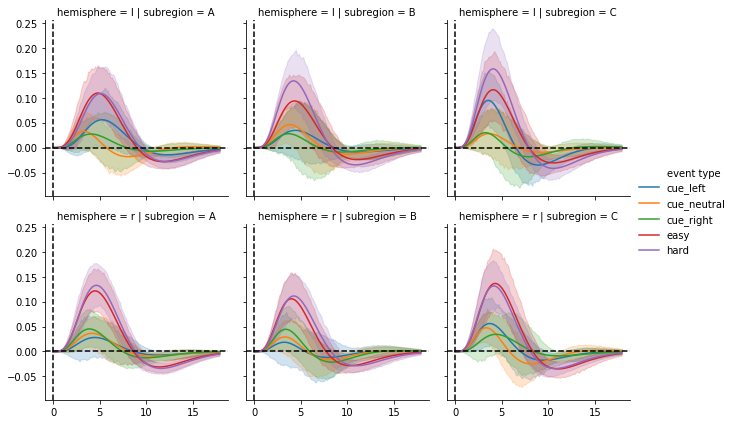

In [519]:
## fit
from nideconv import GroupResponseFitter
gmodel = GroupResponseFitter(df_pivoted, 
                             events, 
                             confounds=confounds_deconv.fillna(0),
                             input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events.event_type.unique():
    gmodel.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
# gmodel.add_event('cue', basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

gmodel.fit()

# get timecourses, plot
tmp = gmodel.get_subjectwise_timecourses()
tmp = tmp.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tmp['hemisphere'] = tmp['roi'].str.split('_').apply(lambda x: x[1])
tmp['subregion'] = tmp['roi'].str.split('_').apply(lambda x: x[2])

## plot
fac = sns.FacetGrid(tmp, row='hemisphere', col='subregion')

fac.map_dataframe(sns.lineplot,
                  x='time',
                  hue='event type',
                  y='signal',
                  color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

## barplots

/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


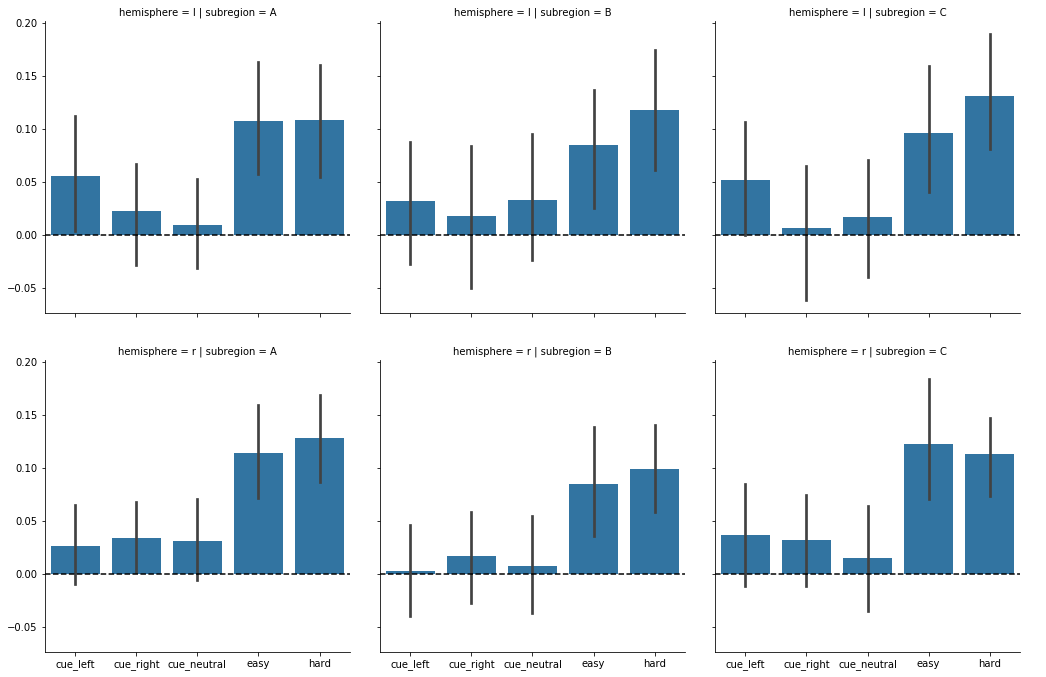

In [557]:
all_betas = pd.concat(gmodel.concat_response_fitters.apply(lambda x: x.betas).values)
all_HRF_betas = all_betas.query('regressor == "HRF"')

# reshape/melt
tmp = all_HRF_betas.reset_index().melt(id_vars=['event type', 'covariate', 'regressor'], var_name='roi', value_name='beta')
tmp['hemisphere'] = tmp['roi'].str.split('_').apply(lambda x: x[1])
tmp['subregion'] = tmp['roi'].str.split('_').apply(lambda x: x[2])

### plot
fac = sns.FacetGrid(tmp, row='hemisphere', col='subregion')

fac.map_dataframe(sns.barplot,
                  x='event type',
#                   hue='event type',
                  y='beta', order=['cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'])
#                   color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(15,10)